<a href="https://colab.research.google.com/github/newb-dev-1008/IRC-Rover-Files/blob/master/Arrow%20Classification%20-%20Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os 
import cv2
import matplotlib.pyplot as plt
import numpy as np
from imutils import paths
import tensorflow as tf
import pandas as pd
import sklearn
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer
import pickle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# Store input data with respective labels

# Path to folder containing the datasets
inputPaths = "/content/drive/MyDrive/College Stuff (B.Tech.)/7th Sem/IRC/Final Datasets for Training"

# All possible labels/ directions
labels = []

# List to store the paths of all images in the dataset
imagePaths = list(paths.list_images(inputPaths))

# This list will be used to store all the images in Bitmap format from OpenCV's imread()
images = []

for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    labels.append(label)
    
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (64, 64))
    
    images.append(image)

In [10]:
from sklearn.model_selection import train_test_split

images = np.array(images)
labels = np.array(labels)

# One-hot encoding of labels to deal with categorical data
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

# Partition the datasets for training and validation (75% train : 25% test)
(trainX, testX, trainY, testY) = train_test_split(images, labels, test_size = 0.25, stratify = labels)

# Initialize the training data augmentation object
trainAug = ImageDataGenerator(rotation_range = 0,
                             zoom_range = 0.15, 
                             width_shift_range = 0.15, 
                             height_shift_range = 0.15, 
                             shear_range = 0.15, 
                             horizontal_flip = False,
                             fill_mode = 'nearest')

# Initialize the validation data augmentation object
valAug = ImageDataGenerator()

# Define the ImageNet Mean Subtraction (in RGB order) and set mean subtraction value 
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean
n_epochs = 50

# **Trial with CNN (ResNet - 50)**

Overkill, may be prone to overfitting. Check below for SVM classifier approach too.

In [21]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report

In [12]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [25]:
with tf.device('/GPU:0'):

    # Changed my mind on number of epochs
    n_epochs = 30

    # Load the ResNet - 50 model, with it's fully connected layers removed
    baseModel = ResNet50(weights = "imagenet", include_top = False, input_tensor = Input(shape = (64, 64, 3)))

    # Construct the fully connected layers to be placed on top of baseModel
    headModel = baseModel.output
    headModel = AveragePooling2D(pool_size = (1, 1))(headModel)
    headModel = Flatten(name = "Flatten_1")(headModel)
    headModel = Dense(128, activation = "relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(len(lb.classes_), activation = "softmax")(headModel)

    # Connect the baseModel and headModel
    model = Model(inputs = baseModel.input, outputs = headModel)

    # Loop through all layers of baseModel and freeze them (make them untrainable)
    # This is necessary to ensure that the ResNet50 weights don't get updated during the process
    for layer in baseModel.layers:
        layer.trainable = False
    
    # Compile the model (after making baseModel non-trainable)
    model.compile(loss = "categorical_crossentropy",
                  optimizer = SGD(lr = 1e-4, momentum = 0.9, decay = (1e-4 / n_epochs)),
                  metrics = ["accuracy"])
    
    # Train the model for n_epochs
    H = model.fit(x = trainAug.flow(trainX, trainY, batch_size = 4),
                  steps_per_epoch = len(trainX) // 4,
                  validation_data = valAug.flow(testX, testY),
                  validation_steps = len(testX) // 4,
                  epochs = n_epochs)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/30
203/203 [==============================] - 6s 19ms/step - loss: 1.5670 - accuracy: 0.4520 - val_loss: 0.8490 - val_accuracy: 0.6199
Epoch 2/30
203/203 [==============================] - 3s 13ms/step - loss: 0.9751 - accuracy: 0.5874
Epoch 3/30
203/203 [==============================] - 3s 13ms/step - loss: 0.7826 - accuracy: 0.6502
Epoch 4/30
203/203 [==============================] - 3s 13ms/step - loss: 0.7388 - accuracy: 0.6502
Epoch 5/30
203/203 [==============================] - 3s 13ms/step - loss: 0.6828 - accuracy: 0.6970
Epoch 6/30
203/203 [==============================] - 3s 13ms/step - loss: 0.6324 - accuracy: 0.7204
Epoch 7/30
203/203 [==============================] - 3s 13ms/step - loss: 0.5900 - accuracy: 0.7488
Epoch 8/30
203/203 [==============================] - 3s 13ms/step - loss: 0.6087 - accuracy: 0.7414
Epoch 9/30
203/203 [==============================] - 3s 13ms/step - loss: 0.5534 - accuracy: 0.7401
Epoch 10/30
203/203 [============================

Evaluating the network:

              precision    recall  f1-score   support

        Left       0.73      0.78      0.76        88
       Right       0.79      0.75      0.77        89
    Straight       0.89      0.87      0.88        94

    accuracy                           0.80       271
   macro avg       0.80      0.80      0.80       271
weighted avg       0.81      0.80      0.80       271



ValueError: ignored

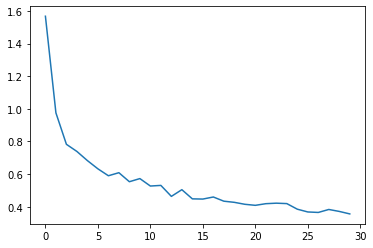

In [26]:
# Evaluate network
print("Evaluating the network:\n")
predictions = model.predict(x = testX.astype("float32"), batch_size = 4)

# Return precision, recall, F1 score
print(classification_report(testY.argmax(axis = 1), predictions.argmax(axis = 1), target_names = lb.classes_))

N = n_epochs

# Plot training loss and accuracy
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label = "train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label = "val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label = "train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label = "val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epochs")
plt.ylabel("Loss/ Accuracy")
plt.legend(loc = "lower left")

In [27]:
# Save the trained model
modelPath = "/content/drive/MyDrive/College Stuff (B.Tech.)/7th Sem/IRC/Saved Models/ResNet - 50/trained_arrow"
model.save(modelPath, save_format = "h5")

# Serialize the LabelBinarizer as well
lbPath = "/content/drive/MyDrive/College Stuff (B.Tech.)/7th Sem/IRC/Saved Models/ResNet - 50/lb_arrow.pickle"
with open(lbPath, "wb") as f:
    f.write(pickle.dumps(lb))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


## **Classification with Plain SVM**

In [ ]:
from skimage.transform import resize
from skimage.io import imread

# Path to folder containing the datasets
inputPaths = "/content/drive/MyDrive/IRC Datasets/Final Datasets for Training"

# All possible labels/ directions
labels = []

# List to store the paths of all images in the dataset
imagePaths = list(paths.list_images(inputPaths))

# This list will be used to store all the images in Bitmap format from OpenCV's imread()
images = []

i = 0
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    labels.append(label)
    
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (64, 64))
    print("Added image: ", i)
    i += 1
    
    images.append(image.flatten())

Added image:  0
Added image:  1
Added image:  2
Added image:  3
Added image:  4
Added image:  5
Added image:  6
Added image:  7
Added image:  8
Added image:  9
Added image:  10
Added image:  11
Added image:  12
Added image:  13
Added image:  14
Added image:  15
Added image:  16
Added image:  17
Added image:  18
Added image:  19
Added image:  20
Added image:  21
Added image:  22
Added image:  23
Added image:  24
Added image:  25
Added image:  26
Added image:  27
Added image:  28
Added image:  29
Added image:  30
Added image:  31
Added image:  32
Added image:  33
Added image:  34
Added image:  35
Added image:  36
Added image:  37
Added image:  38
Added image:  39
Added image:  40
Added image:  41
Added image:  42
Added image:  43
Added image:  44
Added image:  45
Added image:  46
Added image:  47
Added image:  48
Added image:  49
Added image:  50
Added image:  51
Added image:  52
Added image:  53
Added image:  54
Added image:  55
Added image:  56
Added image:  57
Added image:  58
Added i

In [ ]:
print("Number of images: ", len(images))
print("Number of labels: ", len(labels))

Number of images:  1083
Number of labels:  1083


In [ ]:
images = np.array(images)
labels = np.array(labels)

df = pd.DataFrame(images)
df['Labels'] = labels

x = df.iloc[:, : -1]
y = df.iloc[:, -1]

In [ ]:
# SVM Model Construction

from sklearn import svm
from sklearn.model_selection import GridSearchCV, train_test_split

# Initializing model
svc = svm.SVC(probability = True)
params = {'C' : [0.1, 1, 10, 100], 'gamma' : [0.0001, 0.01, 0.1, 1], 'kernel' : ['rbf', 'poly']}
model = GridSearchCV(svc, params)

# Split the train and test datasets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, stratify = y)
with tf.device('/GPU:0'):
  model.fit(x_train, y_train)

In [ ]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# Test the trained model

y_pred = model.predict(x_test)
print("Actual:\n", y_test)
print("Predicted:\n", y_pred)

print("Accuracy: ", (accuracy_score(y_pred, y_test) * 100), "%\n\n")

In [ ]:
# Saving the model

import pickle

fileName = "arrowClassifier.sav"
modelPath = "/content/drive/MyDrive/IRC Datasets/Saved Models/SVM"
os.chdir(modelPath)

pickle.dump(model, open(filename, 'wb'))